In [1]:
import cu_rsc as cr
cr.setup_tables()
import RSC_sim
import numpy as np
import cupy as cp
import cupyx
import matplotlib.pyplot as plt

M_dev = cr.load_m_table_device()        # upload to GPU
res   = cr.resources_from_config(M_dev)

c:\Users\LyuQi\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
seq_ori = np.load("original.npy")

In [6]:
temp = [25e-6, 25e-6, 25e-6]
results = []
k_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
for k in k_list:
    mol_0 = cr.build_thermal_molecules_gpu(1_000, temp)
    cr.raman_cool_with_pumping(
        mol_0, 
        seq_ori, 
        res, 
        show_progress=True, 
        Detuning=(0, 0, 0),
        k_max=k,)

    result = cr.bootstrap_stats_from_molecules(mol_0)
    results.append(result)


Raman pulses: 100%|██████████| 280/280 [00:45<00:00,  6.12it/s]


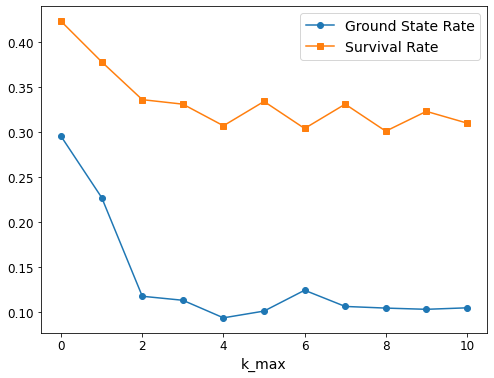

: 

In [ ]:
ground_rates = []
survivals = []
for result in results:
    ground_rates.append(result['ground_state_rate_mean'].get())
    survivals.append(result['survival_rate_mean'].get())

plt.figure(figsize=(8,6))
plt.plot(k_list, ground_rates, marker='o', label='Ground State Rate')
plt.plot(k_list, survivals, marker='s', label='Survival Rate')
plt.xlabel('k_max', fontsize=14)
plt.tick_params(labelsize=12)
plt.legend(fontsize=14)